# 主題：Tripadvisor評論情緒分析與飯店星級預測
#### 第十三組 讀書會第二次討論
組員：
N124020001 林坤郁
N124020004 陳忠泰
N124020005 陳莘惠
N124020006 張祐倫
N124020012 郭展州

#### 資料來源：TripAdvisor Hotel Reviews 
https://www.kaggle.com/datasets/joebeachcapital/hotel-reviews/discussion/448285

+ 飯店星級標準：
    + 一星級飯店 
    + 二星級飯店 
    + 三星級飯店
    + 四星級飯店
    + 五星級飯店   

* 分析主題：將資料集offerings.csv and reviews.csv合起來，訓練模型能預測飯店星級，再用分類模型進行星級的分類。

## 步驟一：匯入必要套件

In [12]:
# 匯入必要套件
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier  # 新增
from sklearn.ensemble import RandomForestClassifier  # 新增

# 設定 matplotlib 繁體中文顯示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 使用微軟正黑體
plt.rcParams['axes.unicode_minus'] = False  # 確保負號正常顯示

## 步驟二：資料載入與初步清理

In [ ]:
# 載入資料
offerings = pd.read_csv("./rowdata/offerings.csv")
reviews = pd.read_csv("./rowdata/reviews.csv")

# 篩選必要欄位
offerings = offerings[['id', 'hotel_class']]
reviews = reviews[['offering_id', 'text']]

# 合併資料
merged_df = pd.merge(reviews, offerings, left_on="offering_id", right_on="id", how="left")

# 篩選有星級的資料並移除缺失值
has_class_df = merged_df[merged_df['hotel_class'].notna()].dropna(subset=['text'])

# 設定最終資料
data = has_class_df[['text', 'hotel_class']]

# 檢視資料
print(f"總評論數: {data.shape[0]}")
print(f"星級分佈:\n{data['hotel_class'].value_counts()}")

# 儲存合併結果以供檢查
merged_df.to_csv("./rowdata/merged_reviews.csv", index=False)
has_class_df.to_csv("./rowdata/hotel_with_class.csv", index=False)

總評論數: 843624
星級分佈:
hotel_class
4.0    288492
3.0    173205
3.5    167315
2.5     69926
2.0     62547
4.5     46595
5.0     29192
1.5      4662
1.0      1690
Name: count, dtype: int64


## 步驟三：資料前處理（清理評論文字）

In [ ]:
# 定義文字清理函數
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # 移除標點符號
    text = re.sub(r'\d+', '', text)      # 移除數字
    text = text.lower().strip()          # 轉為小寫並移除多餘空白
    return text

# 套用清理函數到評論文字
data['clean_text'] = data['text'].apply(clean_text)

# 檢視清理後的前 10 筆資料
print("清理後的前 10 筆資料：")
print(data[['clean_text', 'hotel_class']].head(10))

# 確認星級類別分佈未改變
print(f"\n星級分佈（清理後）:\n{data['hotel_class'].value_counts()}")



清理後的前 10 筆資料：
                                          clean_text  hotel_class
0  stayed in a king suite for  nights and yes it ...          3.0
1  on every visit to nyc the hotel beacon is the ...          3.0
2  this is a great property in midtown we two dif...          4.0
3  the andaz is a nice hotel in a central locatio...          4.0
4  i have stayed at each of the us andaz properti...          4.0
5  excellent staff they remembered our names from...          5.0
6  i stayed at the setai for  nights last week as...          5.0
7  my husband and i stayed at the chatwal for  ni...          5.0
8  wonderful boutique hotel located next to times...          5.0
9  this hotel is a nice stay for nyc because the ...          4.0

星級分佈（清理後）:
hotel_class
4.0    288492
3.0    173205
3.5    167315
2.5     69926
2.0     62547
4.5     46595
5.0     29192
1.5      4662
1.0      1690
Name: count, dtype: int64


C:\Users\rosie.chen\AppData\Local\Temp\ipykernel_25388\2288477226.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_text'] = data['text'].apply(clean_text)


## 步驟四: 切分資料集

In [6]:
# 將 hotel_class 轉為字串類別
data['hotel_class'] = data['hotel_class'].astype(str)

# 切分資料集（7:3 比例）
X = data['clean_text']
y = data['hotel_class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

# 檢查切分比例
print(f"原始資料比例:\n{data['hotel_class'].value_counts(normalize=True) * 100}")
print(f"\n訓練資料比例:\n{y_train.value_counts(normalize=True) * 100}")
print(f"\n測試資料比例:\n{y_test.value_counts(normalize=True) * 100}")

C:\Users\rosie.chen\AppData\Local\Temp\ipykernel_25388\3761581468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hotel_class'] = data['hotel_class'].astype(str)


原始資料比例:
hotel_class
4.0    34.196751
3.0    20.531066
3.5    19.832888
2.5     8.288764
2.0     7.414085
4.5     5.523195
5.0     3.460309
1.5     0.552616
1.0     0.200326
Name: proportion, dtype: float64

訓練資料比例:
hotel_class
4.0    34.210107
3.0    20.521696
3.5    19.818605
2.5     8.275533
2.0     7.420377
4.5     5.543269
5.0     3.463464
1.5     0.552380
1.0     0.194569
Name: proportion, dtype: float64

測試資料比例:
hotel_class
4.0    34.165587
3.0    20.552930
3.5    19.866213
2.5     8.319636
2.0     7.399403
4.5     5.476356
5.0     3.452949
1.5     0.553167
1.0     0.213760
Name: proportion, dtype: float64


## 步驟五：文字轉為 DTM（使用 TF-IDF）

In [7]:
# 初始化 TF-IDF Vectorizer，減少 max_features 為 500
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

# 轉換訓練與測試資料
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

# 檢視轉換後的矩陣形狀
print(f"訓練集矩陣形狀: {vec_train.shape}")
print(f"測試集矩陣形狀: {vec_test.shape}")

訓練集矩陣形狀: (590536, 500)
測試集矩陣形狀: (253088, 500)


## 步驟六：模型訓練與交叉驗證
使用 TF-IDF 特徵訓練多個分類模型（Logistic Regression、Decision Tree、Random Forest），並透過交叉驗證（cross-validation）評估模型表現，輸出分類報告與混淆矩陣。


=== 訓練模型: logistic ===
              precision    recall  f1-score   support

         1.0       0.53      0.01      0.02      1149
         1.5       0.39      0.04      0.08      3262
         2.0       0.38      0.27      0.32     43820
         2.5       0.39      0.14      0.21     48870
         3.0       0.37      0.41      0.39    121188
         3.5       0.38      0.16      0.23    117036
         4.0       0.47      0.82      0.59    202023
         4.5       0.36      0.01      0.02     32735
         5.0       0.47      0.11      0.18     20453

    accuracy                           0.43    590536
   macro avg       0.41      0.22      0.23    590536
weighted avg       0.41      0.43      0.38    590536



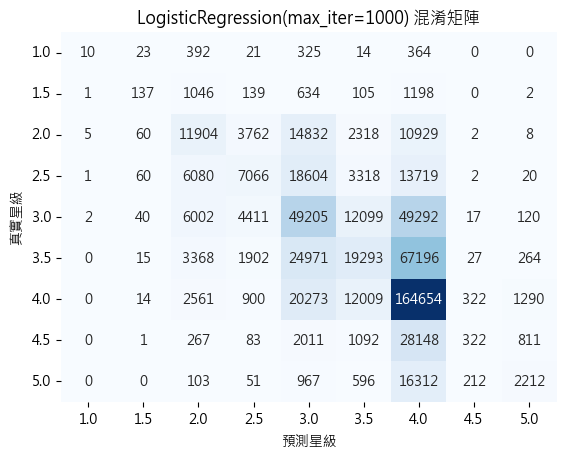


=== 訓練模型: decision_tree ===
              precision    recall  f1-score   support

         1.0       0.02      0.02      0.02      1149
         1.5       0.04      0.03      0.04      3262
         2.0       0.20      0.19      0.19     43820
         2.5       0.19      0.18      0.19     48870
         3.0       0.28      0.29      0.29    121188
         3.5       0.25      0.25      0.25    117036
         4.0       0.45      0.47      0.46    202023
         4.5       0.11      0.10      0.10     32735
         5.0       0.12      0.11      0.11     20453

    accuracy                           0.31    590536
   macro avg       0.18      0.18      0.18    590536
weighted avg       0.30      0.31      0.30    590536



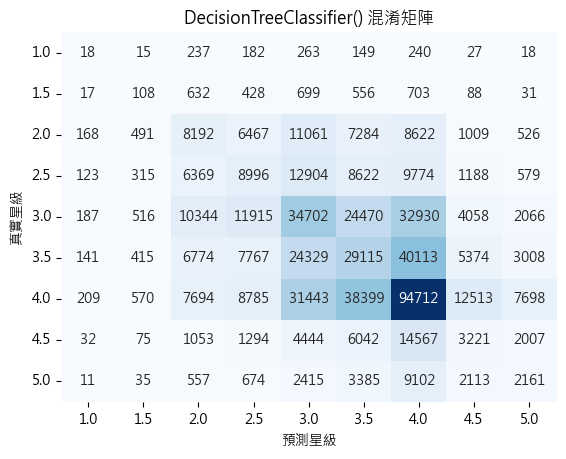


=== 訓練模型: random_forest ===


In [ ]:
# 定義訓練與交叉驗證函數
def train_cv(vectorizer, clf, X, y):
    vec_X = vectorizer.fit_transform(X) 
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    
    # 輸出分類報告
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))
    
    # 從交叉驗證的結果中提取類別
    classes = cv_results['estimator'][0].classes_
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="預測星級",
        ylabel="真實星級",
        xticklabels=classes,
        yticklabels=classes,
        title=f"{str(clf)} 混淆矩陣"
    )
    plt.yticks(rotation=0)
    plt.show()
    
    clf.fit(vec_X, y)
    return cls_report

# 定義模型
model_set = {
    'logistic': LogisticRegression(max_iter=1000),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier()
}

# 儲存結果
result_set = {}
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

# 訓練並評估模型
for name, model in model_set.items():
    print(f"\n=== 訓練模型: {name} ===")
    result_set[name] = train_cv(vectorizer, model, X_train, y_train)